The goal of this notebook is to create the final mgf file that will be used for training Spec2Vec for the negative ionization mode.

In [1]:
from matchms.importing import load_from_mgf

In [2]:
initial_mgf = list(load_from_mgf('/home/ioannis/thesis_data/MSn_filtering_data/merged_and_cleaned_libraries_1.mgf'))

In [3]:
print(len(initial_mgf))

1017531


In [4]:
from collections import Counter
ionmode = [spectrum.get('ionmode') for spectrum in initial_mgf]
print(Counter(ionmode))

Counter({'positive': 702579, 'negative': 314952})


In [5]:
def check_completeness(spectra, metadata):
    total = len(spectra)
    counts = Counter()
    for spectrum in spectra:
        for category in metadata:
            info = spectrum.get(category)
            if info is not None and str(info).strip() != "":
                counts[category] += 1

    print(f"Total spectra: {total}")
    for category in metadata:
        completeness = (counts[category] / total * 100) if total else 0
        print(f"{category:16s}: {counts[category]:6d} / {total}  ({completeness:5.2f}%)")

In [6]:
metadata = ['description', 'formula', 'inchi', 'smiles', 'adduct', 'inchikey', 'collision_energy', 'fragmentation_method', 'ms_mass_analyzer']
check_completeness(initial_mgf, metadata)

Total spectra: 1017531
description     : 304872 / 1017531  (29.96%)
formula         : 1017531 / 1017531  (100.00%)
inchi           : 1017531 / 1017531  (100.00%)
smiles          : 1017531 / 1017531  (100.00%)
adduct          : 1017531 / 1017531  (100.00%)
inchikey        : 1017531 / 1017531  (100.00%)
collision_energy: 406846 / 1017531  (39.98%)
fragmentation_method: 304872 / 1017531  (29.96%)
ms_mass_analyzer: 1017122 / 1017531  (99.96%)


In [7]:
col_energy = [spectrum.get('collision_energy') for spectrum in initial_mgf]
print(Counter(col_energy))

Counter({None: 610685, '60.0': 113315, '20.0': 104517, '30.0': 57233, '45.0': 32485, '15.0': 32450, '6.0': 8616, '35.0': 7999, '40.0': 7297, '10.0': 5725, '90.0': 4436, '75.0': 3575, '50.0': 3384, '80.0': 1978, '120.0': 1908, '70.0': 1709, '150.0': 1679, '25.0': 1556, '100.0': 1196, '110.0': 1085, '55.0': 1032, '33.0': 1029, '130.0': 996, '32.0': 987, '140.0': 962, '34.0': 837, '31.0': 836, '29.0': 803, '180.0': 718, '5.0': 677, '28.0': 636, '36.0': 531, '27.0': 449, '21.0': 409, '23.0': 352, '26.0': 338, '65.0': 313, '43.0': 301, '85.0': 207, '41.0': 196, '105.0': 186, '37.0': 185, '95.0': 165, '24.0': 130, '19.0': 125, '115.0': 116, '22.0': 109, '44.0': 106, '125.0': 92, '42.0': 87, '18.0': 86, '38.0': 82, '17.0': 73, '16.0': 67, '39.0': 60, '0.0': 44, '46.0': 42, '160.0': 27, '53.0': 25, '170.0': 21, '13.0': 21, '11.0': 21, '165.0': 18, '14.0': 18, '135.0': 17, '145.0': 17, '155.0': 17, '175.0': 17, '61.0': 17, '47.0': 17, '185.0': 16, '48.0': 11, '12.0': 10, '49.0': 7, '52.0': 6, '

Split the data into two mgf files based on their ionization mode.

In [8]:
cleaned_pos = [spectrum for spectrum in initial_mgf if spectrum.get("ionmode") == "positive"]
print('Positive: ' , (len(cleaned_pos)))
cleaned_neg = [spectrum for spectrum in initial_mgf if spectrum.get("ionmode") == "negative"]
print('Negative: ' , (len(cleaned_neg)))

Positive:  702579
Negative:  314952


In [9]:
check_completeness(cleaned_neg, metadata)

Total spectra: 314952
description     : 113564 / 314952  (36.06%)
formula         : 314952 / 314952  (100.00%)
inchi           : 314952 / 314952  (100.00%)
smiles          : 314952 / 314952  (100.00%)
adduct          : 314952 / 314952  (100.00%)
inchikey        : 314952 / 314952  (100.00%)
collision_energy: 138912 / 314952  (44.11%)
fragmentation_method: 113564 / 314952  (36.06%)
ms_mass_analyzer: 314922 / 314952  (99.99%)


In [10]:
col_energy_neg = [spectrum.get('collision_energy') for spectrum in cleaned_neg]
print(Counter(col_energy_neg))

Counter({None: 176040, '60.0': 41453, '20.0': 38351, '30.0': 17075, '15.0': 16177, '45.0': 9963, '6.0': 3812, '40.0': 2020, '35.0': 1798, '10.0': 1722, '90.0': 1105, '75.0': 1001, '50.0': 693, '120.0': 437, '80.0': 378, '150.0': 374, '25.0': 365, '5.0': 309, '70.0': 296, '100.0': 247, '110.0': 226, '140.0': 205, '130.0': 197, '180.0': 175, '23.0': 109, '55.0': 108, '43.0': 106, '28.0': 34, '29.0': 16, '53.0': 14, '36.0': 14, '26.0': 10, '65.0': 9, '18.0': 8, '42.0': 8, '34.0': 7, '22.0': 6, '24.0': 5, '19.0': 5, '85.0': 5, '52.0': 5, '48.0': 5, '17.0': 4, '27.0': 4, '38.0': 4, '37.0': 4, '59.0': 3, '47.0': 3, '56.0': 3, '21.0': 2, '95.0': 2, '33.0': 2, '32.0': 2, '31.0': 2, '41.0': 2, '44.0': 2, '57.0': 2, '54.0': 2, '49.0': 2, '51.0': 2, '16.0': 1, '64.0': 1, '63.0': 1, '61.0': 1, '58.0': 1, '101.0': 1, '71.0': 1, '83.0': 1, '105.0': 1, '62.0': 1, '76.0': 1, '13.0': 1})


From the completeness check above, it is obvious that the metadata for the collision energy isn't great. Spec2Vec doesn't need that metadata, but it can be affected by duplicates. The goal here is to filter out spectra that are near-complete duplicates. Near-complete duplicates would have the same inchikey, representing the same molecule. Nonetheless, their fragmentation can be different, due to different adduct or collision energy or other technical reasons. Since the adduct metadata is 100% complete the spectra are going to be grouped using their inchikey and their adduct and then compared using cosine similarity score. Redundant spectra that have above 0.99 similarity are collapsed by only keeping one specta (the one with the best intensity_explained). Outliers are kept, preserving this way the varience and avoiding redundancy at the same time.

In [11]:
import networkx as nx
from collections import defaultdict
from matchms.similarity import CosineGreedy
from matchms import calculate_scores

def filter_redundant_graph(spectra, similarity_threshold=0.99):
    """
    Deduplicate spectra by first grouping on (InChIKey, adduct),
    then clustering within each group using graph-based redundancy filtering.

    Parameters
    ----------
    spectra : list of matchms.Spectrum
        Input spectra to filter.
    similarity_threshold : float, optional
        Cosine similarity cutoff for redundancy (default = 0.99).

    Returns
    -------
    filtered_spectra : list of matchms.Spectrum
        Deduplicated spectra.
    """

    # group spectra by (inchikey, adduct)
    grouped = defaultdict(list)
    for s in spectra:
        key = (s.get("inchikey"), s.get("adduct"))
        grouped[key].append(s)

    filtered = []
    similarity_function = CosineGreedy()

    # cluster within each group one by one
    for group_spectra in grouped.values():
        if len(group_spectra) == 1:
            filtered.extend(group_spectra)
            continue

        # compute all-vs-all similarities inside the group
        scores = calculate_scores(group_spectra, group_spectra, similarity_function)
        scores_array = scores.to_array(name="CosineGreedy_score")

        # Build graph
        G = nx.Graph()
        G.add_nodes_from(range(len(group_spectra))) # each spectra in the group becomes a node
        for i in range(len(group_spectra)):
            for j in range(i+1, len(group_spectra)):
                if scores_array[i, j] >= similarity_threshold:
                    G.add_edge(i, j)

        # Find connected components (connected nodes in the graph)
        clusters = list(nx.connected_components(G))

        # Pick representative per cluster
        for cluster in clusters:
            best = max(
                cluster,
                key=lambda idx: float(group_spectra[idx].get("quality_explained_intensity", 0))
            )
            filtered.append(group_spectra[best])

    print(f"Original spectra: {len(spectra)}")
    print(f"Filtered spectra: {len(filtered)}")
    return filtered


In [12]:
filtered_cleaned_neg = filter_redundant_graph(cleaned_neg)

Original spectra: 314952
Filtered spectra: 193545


In [13]:
unique = []
inchikeys = [spectrum.get('inchikey') for spectrum in filtered_cleaned_neg]
print("Total Number of Inchikeys: ", len(inchikeys))
unique_inchikeys = set(inchikeys)
print('Number of Unique Inchikeys: ', len(unique_inchikeys))

Total Number of Inchikeys:  193545
Number of Unique Inchikeys:  38099


In [14]:
counts_inchikeys = Counter(inchikeys)
print(counts_inchikeys.most_common(10))

[('PFTAWBLQPZVEMU-UHFFFAOYSA-N', 149), ('FBPFZTCFMRRESA-UHFFFAOYSA-N', 83), ('GUBGYTABKSRVRQ-UHFFFAOYSA-N', 69), ('WQZGKKKJIJFFOK-UHFFFAOYSA-N', 66), ('BHQCQFFYRZLCQQ-UHFFFAOYSA-N', 61), ('DRTQHJPVMGBUCF-UHFFFAOYSA-N', 60), ('ZOCSXAVNDGMNBV-UHFFFAOYSA-N', 57), ('JMIAZDVHNCCPDM-UHFFFAOYSA-N', 56), ('REFJWTPEDVJJIY-UHFFFAOYSA-N', 55), ('FTVWIRXFELQLPI-UHFFFAOYSA-N', 52)]


It is obvious that the filtering is not enough at this point since 149 spectra have the same inchikey. We want to allow diversity in the dataset, but we also want to avoid redundancy since that will affect Spec2Vec and introduce bias in the model. The frequency of the "words" (fragments and losses) found together in a "document" (spectrum) is affected 

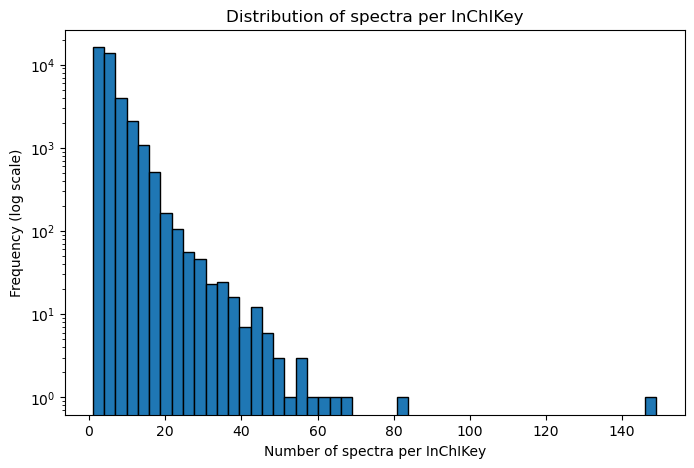

In [44]:
spectra_per_inchikey = list(counts_inchikeys.values())
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(spectra_per_inchikey, bins=50, log=True, edgecolor="black")
plt.xlabel("Number of spectra per InChIKey")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of spectra per InChIKey")
plt.show()

In [15]:
most_common_inchikey = 'PFTAWBLQPZVEMU-UHFFFAOYSA-N'

How many adducts are there for this specific inchikey?

In [16]:
matching_spectra = [s for s in filtered_cleaned_neg if s.get("inchikey") == most_common_inchikey]
adducts = Counter(s.get("adduct") for s in matching_spectra)
print(adducts)

Counter({'[M-H]-': 129, '[2M-H]-': 12, '[M+Cl]-': 4, '[M+HCOOH-H]-': 4})


How many different collision energies are there for this inchikey and this adduct '[M-H]-' in specific?

In [17]:
matching_spectra_adduct = [s for s in filtered_cleaned_neg if s.get("inchikey") == most_common_inchikey and s.get("adduct") == '[M-H]-']
collision_en = Counter(s.get("collision_energy") for s in matching_spectra_adduct)
print(collision_en)

Counter({None: 76, '6.0': 27, '40.0': 6, '60.0': 5, '80.0': 5, '20.0': 4, '10.0': 3, '30.0': 1, '35.0': 1, '25.0': 1})


In [18]:
def bin_ce(ce):
    if ce is None:
        return "unknown"
    try:
        x = float(ce)
    except (TypeError, ValueError):
        return "unknown"
    if x <= 15:
        return "low"
    elif x <= 35:
        return "mid"
    elif x <= 60:
        return "high"
    else:
        return "very_high"


In [19]:
binned = [bin_ce(ce) for ce in col_energy_neg]
print(Counter(binned))

Counter({'unknown': 176040, 'mid': 57806, 'high': 54419, 'low': 22021, 'very_high': 4666})


In [35]:
def curate_stage2(
    spectra,
    similarity_fn,
    sim_threshold_known=0.99,
    sim_threshold_unknown=0.99,
    cap_known=5,
    cap_unknown=3
):
    """
    Stage 2 curation:
    - Group spectra by (inchikey, adduct, analyzer, ce_bin).
    - Deduplicate within each group using cosine similarity.
    - Apply stricter deduplication + lower cap for 'unknown' CE bin.
    - Select representatives by quality_explained_intensity.
    """

    # Group spectra
    groups = defaultdict(list)
    for s in spectra:
        key = (
            s.get("inchikey"),
            s.get("adduct"),
            s.get("ms_mass_analyzer"),
            s.get("ce_bin")  # must be pre-assigned with bin_ce()
        )
        groups[key].append(s)

    curated = []
    for key, group in groups.items():
        ce_bin = key[-1]
        threshold = sim_threshold_unknown if ce_bin == "unknown" else sim_threshold_known
        cap = cap_unknown if ce_bin == "unknown" else cap_known

        if len(group) == 1:
            curated.extend(group)
            continue

        # Compute all-vs-all similarities
        scores = calculate_scores(group, group, similarity_fn)
        A = scores.to_array(name="CosineGreedy_score")

        # Build graph of near-duplicates
        G = nx.Graph()
        G.add_nodes_from(range(len(group)))
        for i in range(len(group)):
            for j in range(i+1, len(group)):
                if A[i, j] >= threshold:
                    G.add_edge(i, j)

        # Cluster and pick representatives
        reps = []
        for cl in nx.connected_components(G):
            best_idx = max(
                cl,
                key=lambda k: float(group[k].get("quality_explained_intensity", 0))
            )
            reps.append(group[best_idx])

        # Cap by quality
        reps.sort(key=lambda s: float(s.get("quality_explained_intensity", 0)), reverse=True)
        curated.extend(reps[:cap])

    return curated

In [36]:
for s in filtered_cleaned_neg:
    s.set("ce_bin", bin_ce(s.get("collision_energy")))

In [37]:
filtered_2 = curate_stage2(filtered_cleaned_neg, similarity_fn=CosineGreedy())

In [38]:
print(len(filtered_2))

172852


It is clear that the second filtering worked as it should, since the dominant bin of unknown collision energies was significantly reduced almost 23%, while the rest of the bins basically remained unchanged.

In [39]:
before_bins = Counter(s.get("ce_bin") for s in filtered_cleaned_neg)
after_bins  = Counter(s.get("ce_bin") for s in filtered_2)

print("Before:", before_bins)
print("After :", after_bins)

Before: Counter({'unknown': 100343, 'mid': 38324, 'high': 37869, 'low': 14074, 'very_high': 2935})
After : Counter({'unknown': 80772, 'mid': 38310, 'high': 37820, 'low': 13335, 'very_high': 2615})


The goal here is to check that no unique inchikeys got lost after the second filtering: Previous unique inchikeys: 38,099

In [40]:

inchikeys_filtered_2 = [spectrum.get('inchikey') for spectrum in filtered_2]
print("Total Number of Inchikeys: ", len(inchikeys_filtered_2))
unique_inchikeys = set(inchikeys_filtered_2)
print('Number of Unique Inchikeys: ', len(unique_inchikeys))

Total Number of Inchikeys:  172852
Number of Unique Inchikeys:  38099


In [41]:
counts_inchikeys_filtered_2 = Counter(inchikeys_filtered_2)
print(counts_inchikeys_filtered_2.most_common(10))

[('PFTAWBLQPZVEMU-UHFFFAOYSA-N', 55), ('ZOCSXAVNDGMNBV-UHFFFAOYSA-N', 48), ('FTVWIRXFELQLPI-UHFFFAOYSA-N', 39), ('REFJWTPEDVJJIY-UHFFFAOYSA-N', 38), ('HKQYGTCOTHHOMP-UHFFFAOYSA-N', 38), ('DJBNUMBKLMJRSA-UHFFFAOYSA-N', 36), ('WIIZWVCIJKGZOK-UHFFFAOYSA-N', 35), ('XMTQQYYKAHVGBJ-UHFFFAOYSA-N', 33), ('SYNOVMDJYWJCON-UHFFFAOYSA-N', 33), ('NJPPVKZQTLUDBO-UHFFFAOYSA-N', 32)]


In [42]:
most_common_inchikey_filtered_2 = 'PFTAWBLQPZVEMU-UHFFFAOYSA-N' # Which is the same inchikey as before the filtering!
matching_spectra_2 = [s for s in filtered_2 if s.get("inchikey") == most_common_inchikey_filtered_2]
ce_for_most_common_inchikey = Counter(s.get("ce_bin") for s in matching_spectra_2)
print(ce_for_most_common_inchikey)


Counter({'unknown': 26, 'mid': 8, 'low': 7, 'high': 7, 'very_high': 7})


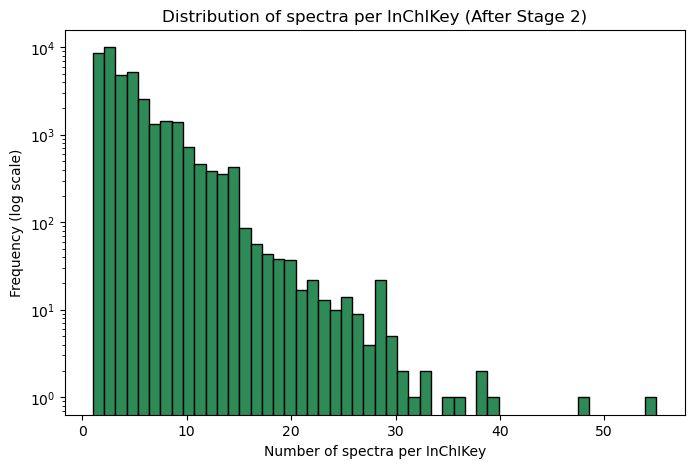

In [45]:
# Count spectra per InChIKey after Stage 2
spectra_per_inchikey_after = list(counts_inchikeys_filtered_2.values())

# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(spectra_per_inchikey_after, bins=50, log=True, edgecolor="black", color="seagreen")
plt.xlabel("Number of spectra per InChIKey")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of spectra per InChIKey (After Stage 2)")
plt.show()

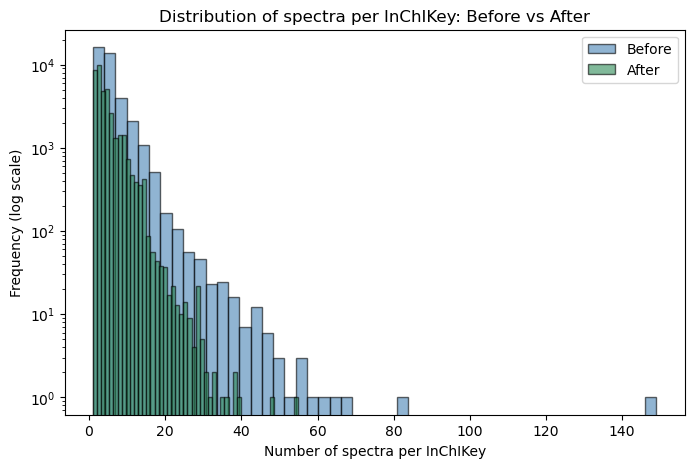

In [46]:
# Plot overlay
plt.figure(figsize=(8,5))
plt.hist(spectra_per_inchikey, bins=50, log=True, alpha=0.6,
         label="Before", color="steelblue", edgecolor="black")
plt.hist(spectra_per_inchikey_after, bins=50, log=True, alpha=0.6,
         label="After", color="seagreen", edgecolor="black")
plt.xlabel("Number of spectra per InChIKey")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of spectra per InChIKey: Before vs After")
plt.legend()
plt.show()

In [47]:
from matchms.exporting import save_as_mgf
output_file = "/home/ioannis/thesis_data/s2v_filtered_2_neg.mgf"
save_as_mgf(filtered_2, output_file)

dict_keys(['spectra'])
